## Post-process CZM simulation result

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns
import math

from scipy.stats import binned_statistic

import warnings
warnings.filterwarnings('ignore')


In [17]:
# read elemental nodal information
cz_ele_info = pd.read_csv('czm_post/cz_ele_info.txt', header=None) 
cz_index = cz_ele_info[0].to_numpy()
cz_ele_info = cz_ele_info.set_index([0])

bulk_ele_info = pd.read_csv('czm_post/bulk_ele_info.txt', header=None) 
bulk_index = bulk_ele_info[0].to_numpy()
bulk_ele_info = bulk_ele_info.set_index([0])

node_info = pd.read_csv('czm_post/node_info.txt', header=None)

# read field output
cz_stress = pd.read_fwf('czm_post/czm_MaxPrincipalStress.rpt', sep=' ', skiprows=7, header=None)
node_displacement = pd.read_csv('czm_post/cz_coat_860D_bend90_20stiff.csv')

# Clean displacement data (log format to datasheet format)

# # index
num_cz = cz_ele_info.shape[0]
num_bulk = bulk_ele_info.shape[0]
num_node = node_info.shape[0]
num_step = cz_stress.shape[0]


### Extract nodal displacement information
#### (Uncomment it if dealing with new data. Re-run takes 20min)

In [18]:
# prepare for nodal loop
temp_df = node_displacement.loc[node_displacement['  Node Label'] == 1]
num_frame = temp_df.shape[1]
num_frame = 1001
used_node = node_displacement['  Node Label'].unique()

# claim space to store u1, u2, x, and y info
nu1 = pd.DataFrame()
nu2 = pd.DataFrame()
nx = pd.DataFrame()
ny = pd.DataFrame()

# select data
for i in range(0, len(used_node)):
    select_df = node_displacement.loc[node_displacement['  Node Label'] == used_node[i]]
    select_df.reset_index(inplace=True)  
    
    node_name = used_node[i]
    
    nu1[node_name] = select_df['        U-U1']
    nu2[node_name] = select_df['        U-U2']
    nx[node_name] = select_df['X']
    ny[node_name] = select_df['Y']

nu1.to_csv('czm_post/860D_bend90_20stiff_nu1_output.csv', float_format='%.4f', index=False)
nu2.to_csv('czm_post/860D_bend90_20stiff_nu2_output.csv', float_format='%.4f', index=False)
nx.to_csv('czm_post/860D_bend90_20stiff_nx_output.csv', float_format='%.4f', index=False)
ny.to_csv('czm_post/860D_bend90_20stiff_ny_output.csv', float_format='%.4f', index=False)

;

nu1 = pd.read_csv('czm_post/860D_bend90_20stiff_nu1_output.csv')
nu2 = pd.read_csv('czm_post/860D_bend90_20stiff_nu2_output.csv')
nx = pd.read_csv('czm_post/860D_bend90_20stiff_nx_output.csv')
ny = pd.read_csv('czm_post/860D_bend90_20stiff_ny_output.csv')

In [5]:
# Calculate the x coordinates (center) of each cz_ele
# thickness of each cz_ele (measure opening)

cz_center = np.empty([num_cz, 2])
cz_delta = np.empty([num_cz, 1001])
cz_delta_final = np.empty([num_cz])
cz_delta_beginning = np.empty([num_cz])

for i in range(0, num_cz):
    cz_i = cz_index[i]
    # for each cz, average the x coord of its four nodes
    ct_x_b = 0
    ct_y_b = 0
    ct_x_t = 0
    ct_y_t = 0

    ct_x_b = nx[str(cz_ele_info[1][cz_i])].iloc[-1] + nx[str(cz_ele_info[2][cz_i])].iloc[-1]
    ct_y_b = ny[str(cz_ele_info[1][cz_i])].iloc[-1] + ny[str(cz_ele_info[2][cz_i])].iloc[-1]
    
    ct_x_t = nx[str(cz_ele_info[3][cz_i])].iloc[-1] + nx[str(cz_ele_info[4][cz_i])].iloc[-1]
    ct_y_t = ny[str(cz_ele_info[3][cz_i])].iloc[-1] + ny[str(cz_ele_info[4][cz_i])].iloc[-1]
    
    cz_delta_final[i] = math.dist([ct_x_b, ct_y_b], [ct_x_t, ct_y_t])

    cz_center[i, 0] = (ct_x_b + ct_x_t) / 4
    cz_center[i, 1] = (ct_y_b + ct_y_t) / 4


    

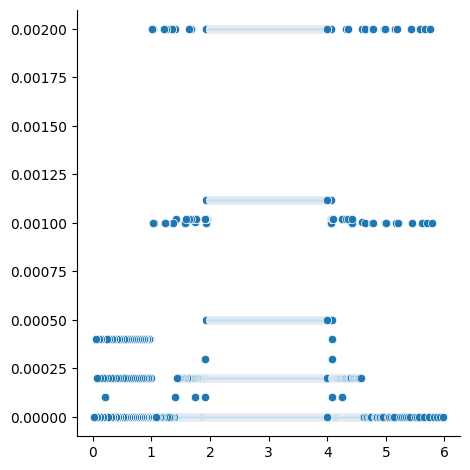

In [7]:
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x=cz_center[:, 0], y=cz_delta_final)


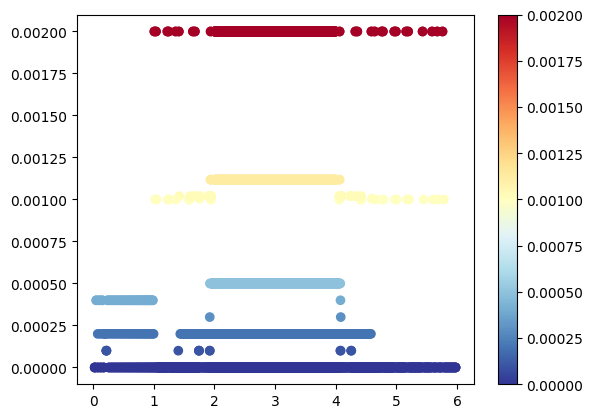

In [8]:
cm = plt.cm.get_cmap('RdYlBu_r')
sc = plt.scatter(cz_center[:, 0], cz_delta_final, c=cz_delta_final,  cmap=cm)
plt.colorbar(sc)
plt.show()

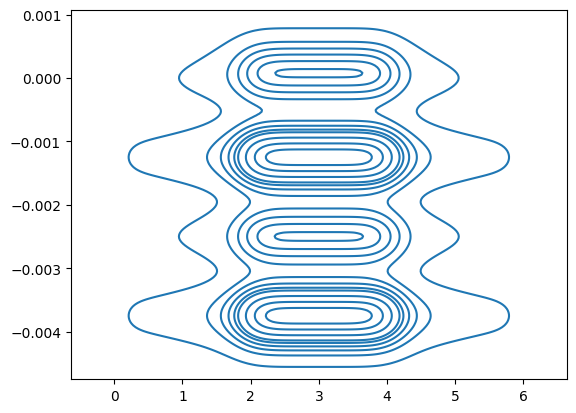

In [9]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_center[:, 1])
plt.show()

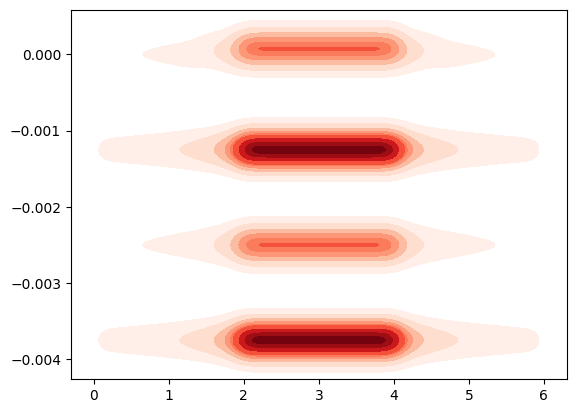

In [10]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_center[:, 1], cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

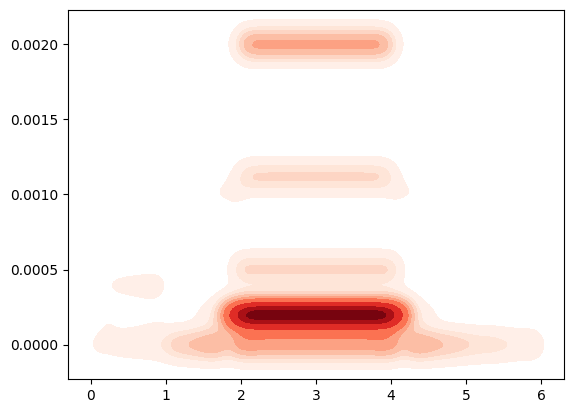

In [12]:
# Basic 2D density plot
sns.kdeplot(x=cz_center[:, 0], y=cz_delta_final, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()

In [ ]:
df_temp = pd.DataFrame(dict(x=cz_center[:, 0], y=cz_center[:, 1], intensity=cz_delta_final))
cz_open_map = df_temp.pivot(index = 'y', columns='x', values='intensity')
sns.heatmap(cz_open_map, annot=False)
plt.axis('off')
# plt.show()

In [ ]:
cz_temp = df_temp
cz_temp.sort_values(by=['x'])

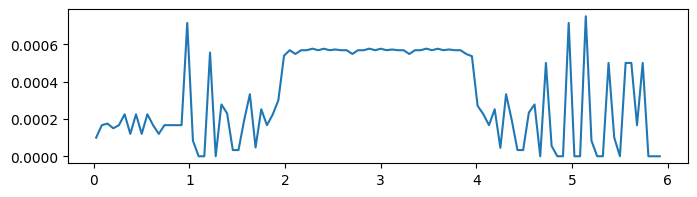

In [15]:
# Compute average crack opening
fig_open = plt.figure(figsize = (8, 2))

mean_stat = binned_statistic(cz_center[:, 0], cz_delta_final, statistic='mean', bins=100)
plt.plot( mean_stat.bin_edges[0:-1], mean_stat.statistic)

cz_open_860D = pd.DataFrame(dict(bin=mean_stat.bin_edges[0:-1], open=mean_stat.statistic))
cz_open_860D.to_csv('czm_post/cz_open_860D.csv', index=False)
# for i in range(0, 6, 0.05):
#     cz_cell = cz_temp.loc[cz_temp['x'] >= i & cz_temp['x'] < i+0.05]




In [ ]:
sns.kdeplot(x=mean_stat.bin_edges[0:-1], y=mean_stat.statistic)
plt.show()

In [ ]:
mean_stat.bin_edges

In [ ]:
# df_temp = node_displacement.groupby("    Node Label")

In [ ]:
# df_temp.reset_index()

In [ ]:
# node_displacement.groupby("    Node Label", group_keys=True)

In [ ]:
# print(df_temp)

In [ ]:
node_displacement.columns.values
